# Analysing Form using Sktime Multivariate Classification

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

Exploring classifiers to analyse multivariate time series of the squat dataset. 

See sktime-univariate-classification to see results of univariate classifiers.

## TOC:
0. [Import Libraries & Setup Helper Functions](#0.-Import-Libraries-&-Setup)
1. [Setup Training & Testing Sets](#1.-Setup-Training-&-Testing-Sets)
2. [Train & Evaluate Models](#2.-Train-&-Evaluate-Models)
    - [ComposableTimeSeriesForest](#Forest-Classifier)
    - [ColumnEnsemble](#Column-Ensemble-Classifier)

# 0. Import Libraries & Setup

In [1]:
! pip install sktime

import sktime
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.compose import (
    ColumnEnsembleClassifier,
    ComposableTimeSeriesForestClassifier
)

from sktime.classification.all import TimeSeriesForestClassifier, KNeighborsTimeSeriesClassifier, ElasticEnsemble
from sktime.classification.kernel_based import Arsenal
from sktime.classification.dictionary_based import WEASEL, BOSSEnsemble
from sktime.classification.hybrid import HIVECOTEV1
from sktime.contrib.vector_classifiers._rotation_forest import RotationForest

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt

In [2]:
# Load
all_videos = pickle.load(open('all-squats.dump', 'rb'))

# Find the shortest and longest length video in terms of frame number
lengths = []

for video in all_videos:
    lengths.append(len(video[1]))
    
shortest_vid = min(lengths)
longest_vid = max(lengths)

In [3]:
# The list we want to convert has format: [{'frame': num, 'coordinates': {'x1'...'z33'}}]
def convert_list_to_df(list_to_convert):
    d = {'frame': []}
    for i in range(33):
        d['x' +  str(i)] = []
        d['y' +  str(i)] = []
        d['z' +  str(i)] = []
    
    for frame in list_to_convert:
        d['frame'].append(frame['frame'])
        for j in range(33):
            d['x' +  str(j)].append(frame['coordinates']['x' + str(j)])
            d['y' +  str(j)].append(frame['coordinates']['y' + str(j)])
            d['z' +  str(j)].append(frame['coordinates']['z' + str(j)])
    return d


# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle


# Get the y differnece between two keypoints in a frame
# INPUT: frame (dictionary of keypoints to coordinates) and the 2 keypoints
# OUPUT: absolute value of the difference
def get_y_difference(frame, keypoint_1, keypoint_2):
    return abs(frame['y'+str(keypoint_1)] - frame['y'+str(keypoint_2)])


# Change a column in a DataFrame to a Series
# INPUT: Column name and DataFrame we want to extract in form {frame number: value at that frame number}
# OUTPUT: Pandas Series of the dictionary formed
def df_column_to_series(name, df):
    out_dict = {}

    largest_frame = 0
    
    for i in range(longest_vid):
        if i >= len(df):
            largest_frame += 1
            out_dict[largest_frame] = 0.0
        else:
            out_dict[int(df.iloc[i]['frame'])-1] = df.iloc[i][name]
            largest_frame = int(df.iloc[i]['frame'])-1
    
    return pd.Series(out_dict)


# Change the shape from: number of frames x features to: 1 x features length for sktime
# INPUT: The DataFrame we want to convert
# OUTPUT: The new converted DataFrame
def df_reshape(df):
    data = {}

    for col in df.columns:
        data[col] = []

    for col in df.columns:
        data[col].append(df_column_to_series(col, df))

    data.pop('frame')
    return pd.DataFrame(data)

# 1. Setup Training & Testing Sets

In [4]:
# Form the testing and training sets
X = []
y = []

for i in all_videos:
    X.append(i[1]) # Coordinates of all frames
    y.append(i[0]) # Video's label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_train = pd.Series(y_train)

print(len(X_train), len(X_test), len(y_train), len(y_test))

60 30 60 30


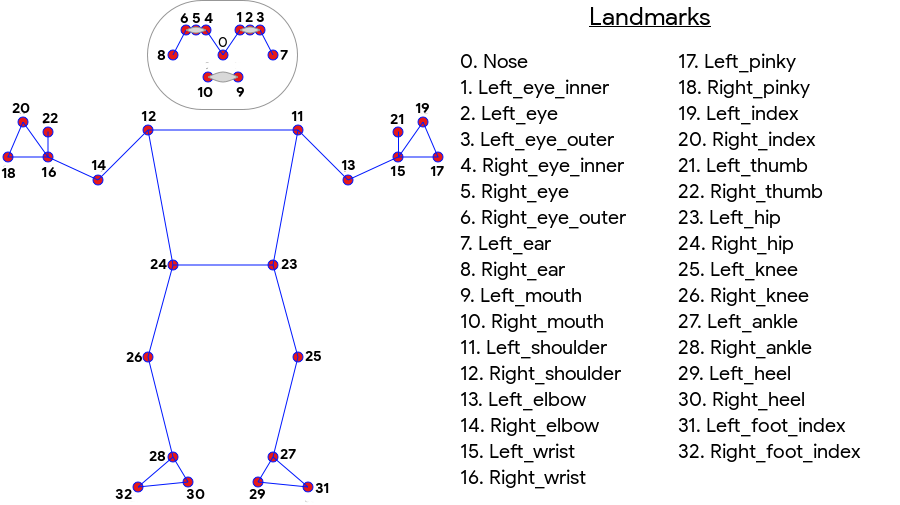

In [5]:
X_train_df = pd.DataFrame()

for vid in X_train:
    df = pd.DataFrame(convert_list_to_df(vid))
    df['knee_hip_difference'] = df.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
    df['hip_angle'] = df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
    X_train_df = X_train_df.append(df_reshape(df))
    
# Fix the index so that they don't all have value of 0    
X_train_df = X_train_df.reset_index(drop=True)

# Multivariate analysis with 2 heursitics
X_train_df = X_train_df.filter(['knee_hip_difference', 'hip_angle'])

In [6]:
X_test_df = pd.DataFrame()

for vid in X_test:
    df = pd.DataFrame(convert_list_to_df(vid))
    df['knee_hip_difference'] = df.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
    df['hip_angle'] = df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
    X_test_df = X_test_df.append(df_reshape(df))
    
# Fix the index so that they don't all have value of 0    
X_test_df = X_test_df.reset_index(drop=True)

# Multivariate analysis with 2 heuristics
X_test_df = X_test_df.filter(['knee_hip_difference', 'hip_angle'])

# 2. Train & Evaluate Models

In [7]:
labels= ['good', 'leaning', 'parallel']

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                   'Accuracy': acc, 
                   'Precision': precision, 
                   'Recall': recall,
                   'F1 Score': f1}

    if display_matrix:
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()

    return model_metrics

Use X_train_df and X_test_df to train classifiers.

Input to classifiers: the difference between the hip and the knee and the hip angle

## Forest Classifier

In [8]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", ComposableTimeSeriesForestClassifier(n_estimators=100, random_state=1)),
]
clf = Pipeline(steps)
clf.fit(X_train_df, y_train)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify',
                 ComposableTimeSeriesForestClassifier(random_state=1))])

In [9]:
y_pred = clf.predict(X_test_df)

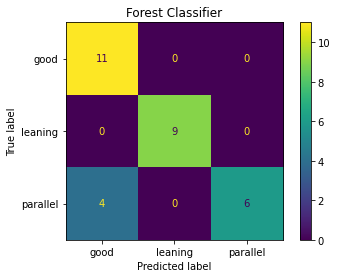

{'Classifier': 'Forest Classifier',
 'Accuracy': 0.8666666666666667,
 'Precision': 0.9111111111111111,
 'Recall': 0.8666666666666667,
 'F1 Score': 0.8666666666666667}

In [10]:
evaluate_model('Forest Classifier', y_pred, True)

## Column Ensemble Classifier

We can use an ensemble of the best performing classifiers for univariate analysis.

See sktime-univariate-classification notebook for performance of the best classifiers.

In [11]:
elastic_clf = ElasticEnsemble(
    proportion_of_param_options=0.1,
    proportion_train_for_test=0.1,
    distance_measures = ["dtw","ddtw"],
    majority_vote=True,
    random_state=1
)

hybrid_clf = HIVECOTEV1(
    stc_params={
        "estimator": RotationForest(n_estimators=3),
        "n_shapelet_samples": 500,
        "max_shapelets": 20,
        "batch_size": 100,
    },
    tsf_params={"n_estimators": 10},
    rise_params={"n_estimators": 10},
    cboss_params={"n_parameter_samples": 25, "max_ensemble_size": 5},
    random_state=1
)

clf = ColumnEnsembleClassifier(
    estimators=[
        ("KNeighbours0", KNeighborsTimeSeriesClassifier(), [0]),
        ("Arsenal0", Arsenal(num_kernels=200, n_estimators=5, random_state=1), [0]),
        ("Elastic0", elastic_clf, [0]),
        ("WEASEL0", WEASEL(window_inc=10, random_state=1), [0]),
#         ("Hybrid0", hybrid_clf, [0]),
#         ("BOSS0", BOSSEnsemble(max_ensemble_size=5), [0]),
        ("Elastic1", elastic_clf, [1]),
#         ("WEASEL1", WEASEL(window_inc=3), [1]),
#         ("Arsenal1", Arsenal(num_kernels=200, n_estimators=5), [1]),
    ]
)
clf.fit(X_train_df, y_train)

ColumnEnsembleClassifier(estimators=[('KNeighbours0',
                                      KNeighborsTimeSeriesClassifier(), [0]),
                                     ('Arsenal0',
                                      Arsenal(n_estimators=5, num_kernels=200,
                                              random_state=1),
                                      [0]),
                                     ('Elastic0',
                                      ElasticEnsemble(distance_measures=['dtw',
                                                                         'ddtw'],
                                                      majority_vote=True,
                                                      proportion_of_param_options=0.1,
                                                      proportion_train_for_test=0.1,
                                                      random_state=1),
                                      [0]),
                                     ('WEASEL0',
          

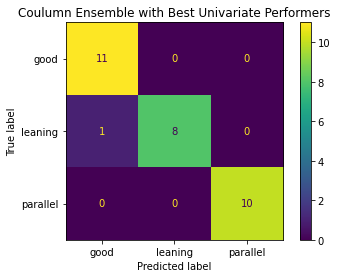

{'Classifier': 'Coulumn Ensemble with Best Univariate Performers',
 'Accuracy': 0.9666666666666667,
 'Precision': 0.9722222222222222,
 'Recall': 0.9629629629629629,
 'F1 Score': 0.9666666666666667}

In [12]:
y_pred = clf.predict(X_test_df)
evaluate_model('Coulumn Ensemble with Best Univariate Performers', y_pred, True)

Putting together the best classifiers generate almost the perfect F1 score.

In [13]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

        good       0.92      1.00      0.96        11
     leaning       1.00      0.89      0.94         9
    parallel       1.00      1.00      1.00        10

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30

